In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
import seaborn as sns
from itertools import product
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq/")
from ddda_dataset import *
import pickle 
from Bio.Seq import Seq
import scipy.stats as ss
%matplotlib inline

In [3]:
# Create folder for saving plots
replicate = "HJR244_12_NoDddA"
plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
if not os.path.exists(plot_dir):
    os.system("mkdir " + plot_dir)

In [4]:
# Create a dictionary for reference regions
ref_range_dict = {
    'HJR244': ('chr11', 5279265, 5282582)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = replicate, 
    region_dict = ref_range_dict, 
    genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
    fastq_file = "/home/yanhu/data/DddA/HJR244/fastqs/" + replicate + "/merged.fastq.gz", 
    working_dir = "/home/yanhu/data/DddA/HJR244/"
)

# Load DddA bias model
bias_model_path = "/home/yanhu/data/DddA/HJR245/bias_dict.pkl"
ddda_data.load_bias_model(bias_model_path)

# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)

# Compute a read-by-position matrix of deletion labels
locus = "HJR244"
del_matrix = ddda_data.del_dict[locus]

Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77050/77050 [00:21<00:00, 3544.25it/s]


70558 reads aligned. 6492 reads unaligned


In [5]:
save_path = "/home/yanhu/data/DddA/HJR244/ddda_data_no_DddA.pkl"
with open(save_path, "wb") as f:
    pickle.dump(ddda_data, f)

In [6]:
agg_error = np.array(np.mean(ddda_data.edit_dict[locus], axis=0))[0]

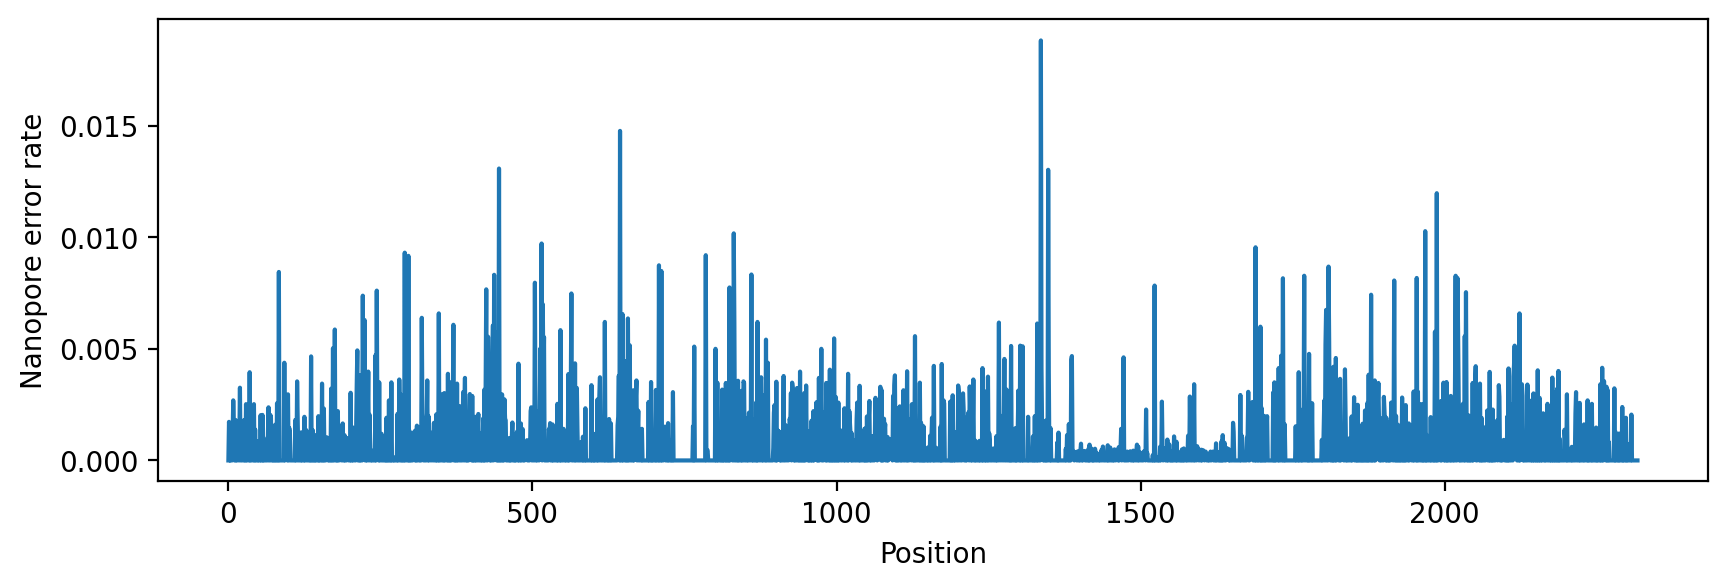

In [7]:
plt.figure(dpi=200, figsize=(10,3))
plt.plot(agg_error[gap_threshold:-gap_threshold])
plt.xlabel("Position")
plt.ylabel("Nanopore error rate")
plt.show()

In [8]:
# Calculate average error rate at cytosine positions for both strands
ref_seq = ddda_data.ref_seq_dict[locus]
C_pos = np.array([i for i in np.arange(len(ref_seq))[gap_threshold:-gap_threshold] if ref_seq[i] == "C"])
G_pos = np.array([i for i in np.arange(len(ref_seq))[gap_threshold:-gap_threshold] if ref_seq[i] == "G"])
print("Average error rate at cytosines on the forward strand", np.mean(agg_error[C_pos]))
print("Average error rate at cytosines on the reverse strand", np.mean(agg_error[G_pos]))

Average error rate at cytosines on the forward strand 0.0024624359315094727
Average error rate at cytosines on the reverse strand 0.0017038678162128176


In [9]:
error_rate = 0.002
C_to_T_threshold = binom.ppf(0.99, len(C_pos), error_rate * 2)
G_to_A_threshold = binom.ppf(0.99, len(G_pos), error_rate * 2)
print("Thresholds for each strand if binomially distributed", C_to_T_threshold, G_to_A_threshold)

Thresholds for each strand if binomially distributed 6.0 6.0


### Compare sequence distance among DddA treated reads and among no DddA reads

In [41]:
path_dict = {
    "no_DddA" : "/home/yanhu/data/DddA/HJR244/ddda_data_no_DddA.pkl",
    "with_DddA_rep1" : "/home/yanhu/data/DddA/HJR244/ddda_data_HJR244_1.pkl",
    "with_DddA_rep2" : "/home/yanhu/data/DddA/HJR244/ddda_data_HJR244_2.pkl"
}

seq_diff_count = {}
edit_count = {}
for sample in path_dict:

    # Load ddda_data for the current sample
    load_path = path_dict[sample]
    with open(load_path, "rb") as f:
        ddda_data = pickle.load(f)
        del_matrix = ddda_data.del_dict[locus]

    # Randomly sample pairs of WT reads (no deletions)
    read_with_del = np.squeeze(np.array(np.max(del_matrix, axis=1).todense()))
    undel_read_inds = np.where(read_with_del == 0)[0]
    sample_1 = np.random.choice(undel_read_inds, 5000)
    sample_2 = np.random.choice(undel_read_inds, 5000)

    # Calculate total number of edits
    edit_count[sample] = np.sum(ddda_data.edit_dict[locus][sample_1, :], axis=1)

    # Calculate number of different edits per pair
    diff_count = np.sum(np.abs(ddda_data.edit_dict[locus][sample_1, :] - ddda_data.edit_dict[locus][sample_2, :]), axis=1)
    diff_count = np.array(diff_count)[:, 0]
    seq_diff_count[sample] = diff_count

In [57]:
ref_seq = ddda_data.ref_seq_dict[locus]
CG_mask = np.arange(len(ref_seq))[ddda_data.start_gap_threshold:-ddda_data.end_gap_threshold]
C_pos = np.array([i for i in CG_mask if ref_seq[i] == "C"])
G_pos = np.array([i for i in CG_mask if ref_seq[i] == "G"])
threshold = int((len(C_pos) + len(G_pos)) * 0.01)

no_DddA 3.541
with_DddA_rep1 85.3434
with_DddA_rep2 86.0278
171.0


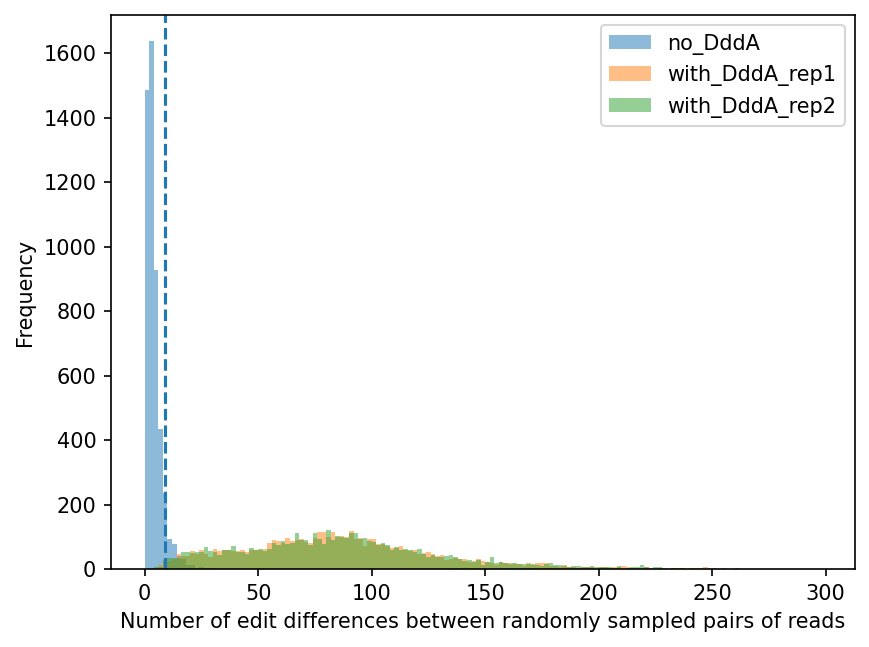

In [62]:
plt.figure(dpi=150)
plt.xlabel("Number of edit differences between randomly sampled pairs of reads")
plt.ylabel("Frequency")
for sample in path_dict:
    print(sample, np.mean(seq_diff_count[sample]))
    plt.hist(seq_diff_count[sample], bins=np.arange(0, 300, 2), label=sample, alpha=0.5)
plt.axvline(x=threshold, linestyle="dashed")
plt.legend()
plt.savefig("/home/yanhu/data/DddA/HJR244/plots/" + replicate + "/random_read_pair_edit_diff_histogram.pdf")
print(np.percentile(diff_count, 95))

no_DddA 1.7892
with_DddA_rep1 48.9742
with_DddA_rep2 49.3112
171.0


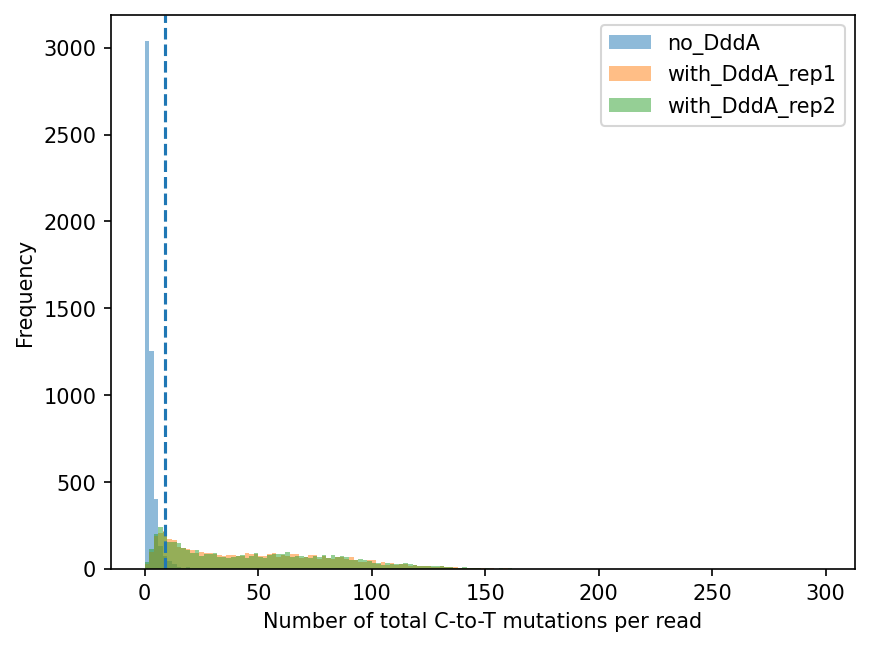

In [63]:
plt.figure(dpi=150)
plt.xlabel("Number of total C-to-T mutations per read")
plt.ylabel("Frequency")
for sample in path_dict:
    print(sample, np.mean(np.array(edit_count[sample]).squeeze()))
    plt.hist(edit_count[sample], bins=np.arange(0, 300, 2), label=sample, alpha=0.5)
plt.axvline(x=threshold, linestyle="dashed")
plt.legend()
plt.savefig("/home/yanhu/data/DddA/HJR244/plots/" + replicate + "/C_to_T_edit_number_histogram.pdf")
print(np.percentile(diff_count, 95))